In [2]:
import os.path
import tensorflow as tf
import helper_cityscape_2class as helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
from datetime import datetime
import time
import numpy as np
%load_ext autoreload
%autoreload 2

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow Version: 1.3.0


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Help Function

In [4]:
def current_time():
    return datetime.utcnow().strftime("%Y%m%d%H%M%S")

In [5]:











from IPython.display import clear_output, Image, display, HTML
import numpy as np

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
    


# Segmentation
## Load pre-trained VGG

In [6]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    image_input = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3_out = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4_out = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7_out = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    # scale layer_3_out, layer_4_out
#     layer_3_out_scaled = tf.multiply(layer3_out, 0.0001, name='layer3_scaled_out')
#     layer_4_out_scaled = tf.multiply(layer4_out, 0.01, name='layer4_scaled_out')

    return image_input, keep_prob, layer3_out, layer4_out, layer7_out


In [6]:
tests.test_load_vgg(load_vgg, tf)

AssertionError: layer3_out is the wrong object

## Create the layers for a fully convolutional network

In [7]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    init = tf.truncated_normal_initializer(stddev = 0.01)
    reg = tf.contrib.layers.l2_regularizer(1e-3)
    def conv_1x1(x, num_classes, init=init):
        return tf.layers.conv2d(x, num_classes, 1, padding='same'
                                          ,kernel_initializer=init
                                          ,kernel_regularizer=reg)
    def upsample(x, num_classes, depth, strides, init=init,name=None):
        return tf.layers.conv2d_transpose(x, num_classes, depth ,strides, padding='same'
                                         ,kernel_initializer=init
                                         ,kernel_regularizer=reg
                                         ,name=name)
    
    layer7_1x1 = conv_1x1(vgg_layer7_out, num_classes)
    layer4_1x1 = conv_1x1(vgg_layer4_out, num_classes)
    layer3_1x1 = conv_1x1(vgg_layer3_out, num_classes)
            
    upsample1 = upsample(layer7_1x1, num_classes, 4, 2)  # kernel=4*4, strides=(2,2)?????
    layer1 = tf.layers.batch_normalization(upsample1)
    layer1 = tf.add(layer1, layer4_1x1)
    
    upsample2 = upsample(layer1, num_classes, 4, 2)
    layer2 = tf.layers.batch_normalization(upsample2)
    layer2 = tf.add(layer2, layer3_1x1)
    
    output = upsample(layer2, num_classes, 16, 8, name='fconv_output')

    return output

In [7]:
tests.test_layers(layers)

Tests Passed


## Optimizer

In [12]:
# Loss with weights
weights = [0.3, 0.6, 0.3]
# Classes are unbalanced, that is why we can add some weight to the road class.
# From https://github.com/MarvinTeichmann/KittiSeg
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    # no need reshape logits, labels to 2d shape
#     cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=nn_last_layer, labels=correct_label)
#                                         ,name = 'cross_entropy_loss')
# #     reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)) # add regularization_loss to loss
# #     loss = tf.add(cross_entropy_loss,reg_loss, name='total_loss')
#     loss =  cross_entropy_loss
    
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#     train_op = optimizer.minimize(loss, name='train_op')
    
#     return nn_last_layer, train_op, loss

    softmax = tf.nn.softmax(nn_last_layer)
    cross_entropy = -tf.reduce_sum(tf.multiply(correct_label * tf.log(softmax), weights), reduction_indices=[3]) # every pixel loss, axis=3 class channel
    cross_entropy_loss = tf.reduce_mean(cross_entropy, name='cross_entropy_loss')                                # image loss = mean(pixel loss); loss = mean(image loss)


    loss = cross_entropy_loss

    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    train_op = optimizer.minimize(loss, name='train_op')
    return nn_last_layer, train_op, loss



## Train Network

In [13]:
def train_nn(sess, epochs, batch_size, get_batches_fn,get_val_batches_fn,
             train_op, loss, predictions,
             input_image, correct_label, keep_prob, learning_rate, saver):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    
    min_val_loss = 1e5
    max_wait_num = 5
    init_wait_num = 0
    for epoch_i in range(1,epochs+1):
        train_loss = []
        steps = 1
        t0 = time.time()
        for images, labels in get_batches_fn(batch_size):
            _, train_batch_loss = sess.run([train_op, loss],
                                feed_dict={input_image: images, correct_label: labels, 
                                           keep_prob:KEEP_PROB, learning_rate:LEARNING_RATE})
            train_loss.append(train_batch_loss)
            steps += 1 
        mean_train_loss = np.mean(np.array(train_loss))
        t1 = time.time() 
            
        ## TODO: every epoch test on validation set, compute loss
        val_loss = []
        for images, labels in get_val_batches_fn(batch_size):
            val_batch_loss = sess.run([loss],
                                     feed_dict={input_image: images, correct_label: labels, keep_prob:1.0})[0]
            val_loss.append(val_batch_loss)
        mean_val_loss = np.mean(np.array(val_loss))
        t2 = time.time() 
        # print every Epoch
        print("Epoch {}/{} \t".format(epoch_i, epochs), 
              "Epoch Train Loss: {:.4f}  Val Loss: {:.4f}  Last Train Batch Loss: {:.4f}".format(mean_train_loss,mean_val_loss, train_batch_loss))
        print("Train an Epoch using {:.2f}, valid using {:.2f}".format(t1-t0,t2-t1))
        
        # early stop
        if min_val_loss > mean_val_loss:
            min_val_loss = mean_val_loss
            init_wait_num = 0
            model_path = "./models/models2class-{}-{:.4f}-{}/".format(epoch_i,mean_val_loss,current_time())
            save_path = saver.save(sess, model_path+"segmentation_model.ckpt")
            
#                 # run on test images, save test images with mask
#             mean_iou = helper.save_inference_samples(runs_dir, test_dataset_dir, sess, image_shape, predictions,
#                                              keep_prob, input_image, epoch=epoch_i, mini=True,  compute_iou=True)
#             print("Epoch:{}  Test Mean iou:{}".format(epoch_i, mean_iou))
        else:
            init_wait_num += 1
            if init_wait_num >= max_wait_num:
                break
            
        
    
    # using last model run on test images, save test images with mask
#     mean_iou = helper.save_inference_samples(runs_dir, test_dataset_dir, sess, image_shape, predictions,
#                                              keep_prob, input_image, epoch=epoch_i, mini=True,  compute_iou=True)
#     print("Test Mean iou: ",mean_iou )
    
    return model_path
        
    
       

## Train Model

### Seperate

In [18]:
num_classes = 3
image_shape = (256, 512)
data_dir = './data'
runs_dir = './runs'
logs_dir = './tf_logs'
train_dataset_dir = './data/leftImg8bit/train_ds/'
val_dataset_dir = './data/leftImg8bit/val_ds/'
test_dataset_dir = './data/leftImg8bit/test_ds/'
gt_dataset_dir = './data/leftImg8bit/gt_ds/'
epochs = 1
batch_size = 2

# Download pretrained vgg model
helper.maybe_download_pretrained_vgg(data_dir)
    

In [15]:
tf.reset_default_graph()

In [16]:

sess = tf.InteractiveSession()

# Path to vgg model
vgg_path = os.path.join(data_dir, 'vgg')
# Create function to get train batches
get_train_batches_fn = helper.gen_batch_function(train_dataset_dir, image_shape, augment=True)
get_val_batches_fn = helper.gen_batch_function(val_dataset_dir, image_shape, augment=False)

##--------------------------------------Construction--------------------------------------##
print(".....................build network")
input_image, keep_prob, layer_3_out, layer_4_out, layer_7_out = load_vgg(sess, vgg_path)
# scale layer_3_out, layer_4_out


# build fully conv layers; skip layers
output = layers(layer_3_out, layer_4_out, layer_7_out, num_classes)


correct_label = tf.placeholder(tf.float32, shape = [None, None, None, num_classes],name='correct_label')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

logits, train_op, loss = optimize(output, correct_label, learning_rate, num_classes) # logits =output, 4d dimension

#prediction; 
predictions = tf.argmax(tf.nn.softmax(logits), axis=-1, name='predictions')


sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
saver = tf.train.Saver()

print("......................training")
model_path = train_nn(sess, epochs, batch_size, get_train_batches_fn,get_val_batches_fn,
                     train_op, loss, predictions,
                     input_image, correct_label, keep_prob, learning_rate, saver)


.....................build network
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
......................training
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(51

(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024

(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024, 3)
(512, 1024

KeyboardInterrupt: 

In [17]:
sess.close()

### entirety

In [8]:
# tf.reset_default_graph
num_classes = 3
image_shape = (256, 512)
LEARNING_RATE = 1e-4
KEEP_PROB = 0.5
data_dir = './data'
runs_dir = './runs'
logs_dir = './tf_logs'
train_dataset_dir = './data/leftImg8bit/train_ds/'
val_dataset_dir = './data/leftImg8bit/val_ds/'
test_dataset_dir = './data/leftImg8bit/test_ds/'
gt_dataset_dir = './data/leftImg8bit/gt_ds/'


# Download pretrained vgg model
helper.maybe_download_pretrained_vgg(data_dir)

In [9]:
# tf.reset_default_graph
def run(num_epochs, batch_size):
    num_classes = 3
    image_shape = (256, 512)
    data_dir = './data'
    runs_dir = './runs'
    logs_dir = './tf_logs'
    train_dataset_dir = './data/leftImg8bit/train_ds/'
    val_dataset_dir = './data/leftImg8bit/val_ds/'
    test_dataset_dir = './data/leftImg8bit/test_ds/'
    gt_dataset_dir = './data/leftImg8bit/gt_ds/'
    epochs = num_epochs
    batch_size = batch_size

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)
    
    tf.reset_default_graph()
    
    with tf.Session() as sess:

        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get train batches
        get_train_batches_fn = helper.gen_batch_function(train_dataset_dir, image_shape, augment=True)
        get_val_batches_fn = helper.gen_batch_function(val_dataset_dir, image_shape, augment=False)

        ##--------------------------------------Construction--------------------------------------##
        print(".....................build network")
        input_image, keep_prob, layer_3_out, layer_4_out, layer_7_out = load_vgg(sess, vgg_path)
        # scale layer_3_out, layer_4_out


        # build fully conv layers; skip layers
        output = layers(layer_3_out, layer_4_out, layer_7_out, num_classes)


        correct_label = tf.placeholder(tf.float32, shape = [None, None, None, num_classes],name='correct_label')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')

        logits, train_op, loss = optimize(output, correct_label, learning_rate, num_classes) # logits =output, 4d dimension

        #prediction; 
        predictions = tf.argmax(tf.nn.softmax(logits), axis=-1, name='predictions')


        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        saver = tf.train.Saver()

        print("......................training")
        model_path = train_nn(sess, epochs, batch_size, get_train_batches_fn,get_val_batches_fn,
                             train_op, loss, predictions,
                             input_image, correct_label, keep_prob, learning_rate, saver)
    return model_path

In [ ]:
# road car； data augumentation
model_path = run(num_epochs=15, batch_size=32)

.....................build network
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
......................training


In [14]:
# road car
model_path = run(num_epochs=15, batch_size=32)

.....................build network
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'


KeyboardInterrupt: 

In [ ]:
# road car
model_path = run(num_epochs=20, batch_size=32)

.....................build network
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
......................training
Epoch 1/20 	 Epoch Train Loss: 0.5274  Val Loss: 0.3152  Last Train Batch Loss: 0.3216
Train an Epoch using 215.39, valid using 18.82
Epoch 2/20 	 Epoch Train Loss: 0.2054  Val Loss: 0.1447  Last Train Batch Loss: 0.1449
Train an Epoch using 204.08, valid using 17.07
Epoch 3/20 	 Epoch Train Loss: 0.1359  Val Loss: 0.1175  Last Train Batch Loss: 0.1135
Train an Epoch using 204.82, valid using 16.98
Epoch 4/20 	 Epoch Train Loss: 0.1027  Val Loss: 0.1078  Last Train Batch Loss: 0.0984
Train an Epoch using 202.88, valid using 17.21
Epoch 5/20 	 Epoch Train Loss: 0.0812  Val Loss: 0.1015  Last Train Batch Loss: 0.0826
Train an Epoch using 202.60, valid using 16.99
Epoch 6/20 	 Epoch Train Loss: 0.0712  Val Loss: 0.0816  Last Train Batch Loss: 0.0802
Train an Epoch using 202.85, valid using 17.03
Epoch 7/20 	 Epoch Train Loss: 0.0632  Val Loss: 0.063

In [9]:
# road
model_path = run(num_epochs=15, batch_size=32)

.....................build network
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
......................training
Epoch 1/15 	 Epoch Train Loss: 0.2848  Val Loss: 0.1513  Last Train Batch Loss: 0.1550
Train an Epoch using 192.16, valid using 14.58
Epoch 2/15 	 Epoch Train Loss: 0.1283  Val Loss: 0.1266  Last Train Batch Loss: 0.1246
Train an Epoch using 185.03, valid using 13.65
Epoch 3/15 	 Epoch Train Loss: 0.1058  Val Loss: 0.1221  Last Train Batch Loss: 0.1029
Train an Epoch using 183.14, valid using 13.65
Epoch 4/15 	 Epoch Train Loss: 0.0956  Val Loss: 0.1060  Last Train Batch Loss: 0.1225
Train an Epoch using 186.89, valid using 13.66
Epoch 5/15 	 Epoch Train Loss: 0.0881  Val Loss: 0.1058  Last Train Batch Loss: 0.0909
Train an Epoch using 185.50, valid using 13.65
Epoch 6/15 	 Epoch Train Loss: 0.0830  Val Loss: 0.0963  Last Train Batch Loss: 0.0941
Train an Epoch using 187.02, valid using 13.85
Epoch 7/15 	 Epoch Train Loss: 0.0771  Val Loss: 0.109

In [10]:
# model_path = './models/models-2-0.1422-20180116082602/'
# model_path = './models/models-9-0.0985-20180116093708/'
model_path 


'./models/models-6-0.0963-20180116110228/'

## reload model

In [5]:
train_dataset_dir = './data/leftImg8bit/train_ds/'
val_dataset_dir = './data/leftImg8bit/val_ds/'
test_dataset_dir = './data/leftImg8bit/test_ds/'
gt_dataset_dir = './data/leftImg8bit/gt_ds/'
runs_dir = './runs'
image_shape=(256,512)
batch_size = 32

In [6]:
model_path = './models/models2class-10-0.0592-20180120052021/'

In [7]:
import tensorflow as tf

sess=tf.InteractiveSession()    
#First let's load meta graph and restore weights
# model_path = './models/models-25-0.0397-20180115135701/'
best_epoch = model_path.split("-")[1]
saver = tf.train.import_meta_graph(model_path+'segmentation_model.ckpt.meta')
saver.restore(sess, model_path + 'segmentation_model.ckpt')


# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

test_input = graph.get_tensor_by_name('image_input:0')
test_label = graph.get_tensor_by_name('correct_label:0')
test_keep_prob = graph.get_tensor_by_name('keep_prob:0')
# test_learning_rate = graph.get_tensor_by_name('learning_rate:0')
test_predictions = graph.get_tensor_by_name('predictions:0')
test_loss = graph.get_tensor_by_name('cross_entropy_loss:0')

INFO:tensorflow:Restoring parameters from ./models/models2class-10-0.0592-20180120052021/segmentation_model.ckpt


In [19]:
test_train_op = graph.get_operation_by_name("train_op")
test_learning_rate = graph.get_tensor_by_name('learning_rate:0')
get_train_batches_fn = helper.gen_batch_function(train_dataset_dir, image_shape)
get_val_batches_fn = helper.gen_batch_function(val_dataset_dir, image_shape)
epochs=15

In [21]:
# sess.run(tf.global_variables_initializer())
# sess.run(tf.local_variables_initializer())
saver = tf.train.Saver()

print("......................training")
model_path = train_nn(sess, epochs, batch_size, get_train_batches_fn,get_val_batches_fn,
                     test_train_op, test_loss, test_predictions,
                     test_input, test_label, test_keep_prob, test_learning_rate, saver)

......................training


NameError: name 'KEEP_PROB' is not defined

In [23]:
# only compute iou
from scipy.misc import imread
road_color = np.array([128, 64, 128, 255])
def compute_img_iou(label_file, prediction, gt_dataset_dir='./data/leftImg8bit/gt_ds/'):
    label_image = imread(os.path.join(gt_dataset_dir, label_file))
    label = np.all(label_image == road_color, axis=2).reshape(-1,1).astype(np.float32)
    prediction = prediction.reshape(-1,1).astype(np.float32)

    inter = np.sum(label * prediction)
    union = max(np.sum(label + prediction) - inter, 1)
    iou = inter*1./union
    return iou

    
def compute_test_iou(sess, predictions, keep_prob, image_pl, test_data_folder='./data/leftImg8bit/test_ds/'):

    image_files = os.listdir(test_data_folder)
    ious = []
    for image_file in image_files:
        image = imread(os.path.join(test_data_folder, image_file))
        prediction = sess.run([predictions],
                                {keep_prob: 1.0, image_pl: [image]})[0]
        label_file = image_file
        iou = compute_img_iou(label_file, prediction)
        ious.append(iou)
    return np.mean(np.array(ious))

compute_test_iou(sess, test_predictions, test_keep_prob, test_input)

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


inter: 0.0
union: 51112.0
inter: 0.0
union: 53725.0
inter: 0.0
union: 48592.0
inter: 0.0
union: 40971.0
inter: 0.0
union: 46948.0
inter: 0.0
union: 37398.0
inter: 0.0
union: 29406.0
inter: 0.0
union: 40736.0
inter: 0.0
union: 53015.0
inter: 0.0
union: 56673.0
inter: 0.0
union: 27554.0
inter: 0.0
union: 44575.0
inter: 0.0
union: 42993.0
inter: 0.0
union: 33984.0
inter: 0.0
union: 39283.0
inter: 0.0
union: 36786.0
inter: 0.0
union: 44691.0
inter: 0.0
union: 12638.0
inter: 0.0
union: 34481.0
inter: 0.0
union: 42704.0
inter: 0.0
union: 40000.0
inter: 0.0
union: 36914.0
inter: 0.0
union: 50455.0
inter: 0.0
union: 41463.0
inter: 0.0
union: 46902.0
inter: 0.0
union: 32312.0
inter: 0.0
union: 38312.0
inter: 0.0
union: 42678.0
inter: 0.0
union: 51355.0
inter: 0.0
union: 38008.0
inter: 0.0
union: 38369.0
inter: 0.0
union: 54779.0
inter: 0.0
union: 55867.0
inter: 0.0
union: 49384.0
inter: 0.0
union: 33630.0
inter: 0.0
union: 37760.0
inter: 0.0
union: 33110.0
inter: 0.0
union: 35493.0
inter: 0.0
u

inter: 0.0
union: 22719.0
inter: 0.0
union: 38585.0
inter: 0.0
union: 48074.0
inter: 0.0
union: 58793.0
inter: 0.0
union: 41156.0
inter: 0.0
union: 43119.0
inter: 0.0
union: 45322.0
inter: 0.0
union: 37262.0
inter: 0.0
union: 52364.0
inter: 0.0
union: 40099.0
inter: 0.0
union: 40633.0
inter: 0.0
union: 53822.0
inter: 0.0
union: 42114.0
inter: 0.0
union: 47556.0
inter: 0.0
union: 43121.0
inter: 0.0
union: 45812.0
inter: 0.0
union: 43523.0
inter: 0.0
union: 49023.0
inter: 0.0
union: 48977.0
inter: 0.0
union: 37678.0
inter: 0.0
union: 42329.0
inter: 0.0
union: 47371.0
inter: 0.0
union: 24329.0
inter: 0.0
union: 52216.0
inter: 0.0
union: 50136.0
inter: 0.0
union: 50963.0
inter: 0.0
union: 56442.0
inter: 0.0
union: 52953.0
inter: 0.0
union: 56512.0
inter: 0.0
union: 48072.0
inter: 0.0
union: 43693.0
inter: 0.0
union: 37799.0
inter: 0.0
union: 42878.0
inter: 0.0
union: 34511.0
inter: 0.0
union: 45363.0
inter: 0.0
union: 29821.0
inter: 0.0
union: 53278.0
inter: 0.0
union: 47322.0
inter: 0.0
u

KeyboardInterrupt: 

In [31]:
# compute prediction useing time
image_files = os.listdir(val_dataset_dir)[:100]
t = 0
for image_file in image_files:
    image = imread(os.path.join(val_dataset_dir, image_file))
    t1 = time.time()
    prediction = sess.run([test_predictions],
                            {test_keep_prob: 1.0, test_input: [image]})[0]
    t = t+ (time.time()-t1)
avg_time = t/100
print("avg prediction time: {:.4f}".format(avg_time))

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


NameError: name 'avg_trime' is not defined

In [32]:
print("avg prediction time: {:.4f}".format(avg_time))

avg prediction time: 0.0623


In [8]:
# testset: add mask, compute iou
# road car
val_mean_iou = helper.save_inference_samples(runs_dir, val_dataset_dir, sess, image_shape, 
                                         test_predictions, test_keep_prob, test_input, 
                                         best_epoch, mini=False, compute_iou=True)
print("Val mean iou: ",val_mean_iou)

Training Finished. Saving test images to: ./runs/total_test-10-20180121063151
Val mean iou:  [ 0.8971258   0.84495949  0.60294279]


In [14]:
# testset: add mask, compute iou
# road car
val_mean_iou = helper.save_inference_samples(runs_dir, val_dataset_dir, sess, image_shape, 
                                         test_predictions, test_keep_prob, test_input, 
                                         best_epoch, mini=False, compute_iou=True)
print("Val mean iou: ",val_mean_iou)

Training Finished. Saving test images to: ./runs/total_test-17-20180118152710
Val mean iou:  [ 0.94059989  0.90243197  0.65623379]


In [ ]:
print("Finish!!!!!  \t shut down machine!!!!")

In [7]:
# testset: add mask, compute iou
# road
val_mean_iou = helper.save_inference_samples(runs_dir, val_dataset_dir, sess, image_shape, 
                                         test_predictions, test_keep_prob, test_input, 
                                         best_epoch, mini=False, compute_iou=True)
print("Val mean iou: ",val_mean_iou)

call save_inference_samples
Training Finished. Saving test images to: ./runs/total_test-6-20180116122534
Val mean iou:  0.872832169391


In [ ]:
 # compute test loss   
def compute_test_loss(dataset_dir,image_shape,loss,input_image,correct_label,keep_prob):
    get_test_batches_fn = helper.gen_batch_function(dataset_dir, image_shape)
    test_loss = []
    for images, labels in get_test_batches_fn(batch_size):
        test_batch_loss = sess.run([loss],
                                 feed_dict={input_image: images, correct_label: labels, keep_prob:1.0})[0]
        test_loss.append(test_batch_loss)
    mean_test_loss = np.mean(np.array(test_loss))
    return mean_test_loss

mean_test_loss = compute_test_loss(test_dataset_dir,image_shape,test_loss,test_input,test_label,test_keep_prob)
print("Test set loss: ",mean_test_loss)

### other images

In [50]:
import scipy

kiti_dir = "./kiti_image/"
image_files = os.listdir(kiti_dir)
output_dir = runs_dir+'/others'
for image_file in image_files:
    image = scipy.misc.imresize(scipy.misc.imread(os.path.join(kiti_dir, image_file)),image_shape,interp='bilinear')


    prediction = sess.run([test_predictions],
                            {test_keep_prob: 1.0, test_input: [image]})[0]
    street_im = scipy.misc.toimage(image)

    # road
    segmentation = prediction.reshape(*image_shape,1).astype(np.int8)
    mask = np.dot(segmentation, np.array([[128, 64, 128, 64]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    street_im.paste(mask, box=None, mask=mask)
    scipy.misc.imsave(os.path.join(output_dir, image_file), street_im)


/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if __name__ == '__main__':
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be rem

In [33]:
sess.close()

# Error  Analysis


In [18]:
 # compute test loss   
road_color = np.array([128, 64, 128, 255])
car_color = np.array([0, 0, 142, 255])   


val_fnames = os.listdir(val_dataset_dir)
image_paths = [os.path.join(val_dataset_dir, fname) for fname in val_fnames]
label_paths = [os.path.join(gt_dataset_dir, fname) for fname in val_fnames]

def get_gt_label(label_path):
    gt_image= imread(label_path)
    gt_road = np.all(gt_image == road_color, axis=2)
    gt_road = gt_road.reshape(*gt_road.shape, 1)
    gt_car = np.all(gt_image == car_color, axis=2)
    gt_car = gt_car.reshape(*gt_car.shape, 1)
    gt_obj = np.concatenate((gt_road, gt_car), axis=2)
    gt_bg = np.all(gt_obj == 0, axis=2)
    gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
#     gt_image = np.concatenate((np.invert(gt_road), gt_road), axis=2)
    gt_image = np.concatenate((gt_bg, gt_obj), axis=2) # channel: bg, road, car
    return gt_image

def get_tuples_fname_loss():
    tuples_fname_loss = []
    for image_path, label_path in zip(image_paths,label_paths):
        image = imread(image_path)
        label = get_gt_label(label_path)
        test_batch_loss = sess.run([test_loss],
                                 feed_dict={test_input: [image], test_label: [label], test_keep_prob:1.0})[0]

        tuples_fname_loss.append((os.path.basename(image_path),test_batch_loss))
    return sorted(tuples_fname_loss, key=lambda tup: tup[1], reverse=True) # sort by loss



In [19]:
from scipy.misc import imread,imsave,imresize

tuples_fname_loss_sorted = get_tuples_fname_loss()
print("Test set loss: ",tuples_fname_loss_sorted)

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


Test set loss:  [('lindau_000034_000019.png', 0.49316773), ('lindau_000051_000019.png', 0.37822485), ('lindau_000044_000019.png', 0.32606861), ('lindau_000053_000019.png', 0.32569969), ('lindau_000019_000019.png', 0.32510179), ('lindau_000035_000019.png', 0.29417825), ('lindau_000018_000019.png', 0.2866762), ('munster_000148_000019.png', 0.27217621), ('lindau_000024_000019.png', 0.27124301), ('lindau_000046_000019.png', 0.26185524), ('lindau_000031_000019.png', 0.25971502), ('frankfurt_000001_002759.png', 0.20430894), ('lindau_000047_000019.png', 0.1887258), ('lindau_000052_000019.png', 0.18843791), ('lindau_000017_000019.png', 0.18332782), ('munster_000133_000019.png', 0.18000732), ('frankfurt_000001_017459.png', 0.17720331), ('munster_000001_000019.png', 0.17040893), ('lindau_000050_000019.png', 0.16748592), ('lindau_000001_000019.png', 0.16667414), ('lindau_000045_000019.png', 0.1543214), ('lindau_000030_000019.png', 0.14502566), ('frankfurt_000001_050686.png', 0.14106274), ('munste

In [20]:
def get_large_loss_tuples(tuples, margin):
    return [tup for tup in tuples if (tup[1]<margin[0] and tup[1]>= margin[1])]


5


In [22]:
def showimg(img_path, loss= None):
    img = imread(img_path)
    fname = os.path.basename(img_path)
    plt.figure()
    print("file name:{} loss:{}".format(fname,loss))
    plt.imshow(img)
    plt.show()

In [ ]:
def draw_large_loss_images(res_dir='./runs/total_test-17-20180118152710/'):
    for fname, loss in large_loss_tuples:
        img_path= res_dir+fname
        showimg(img_path,loss)

In [25]:
# loss 在(0.5, 0.3] 都是把ground当成road
large_loss_tuples = get_large_loss_tuples(tuples_fname_loss_sorted, [0.5,0.3])
print(len(large_loss_tuples))

5


In [21]:
for fname, loss in large_loss_tuples:
    print("file name:{} loss:{}".format(fname,loss))

file name:lindau_000034_000019.png loss:0.4931677281856537
file name:lindau_000051_000019.png loss:0.37822484970092773
file name:lindau_000044_000019.png loss:0.32606860995292664
file name:lindau_000053_000019.png loss:0.32569968700408936
file name:lindau_000019_000019.png loss:0.3251017928123474


In [28]:
# loss 在(0.3, 0.2] 都是把ground当成road
# 除了
# file name:lindau_000024_000019.png loss:0.27124300599098206
# file name:lindau_000031_000019.png loss:0.2597150206565857
# file name:frankfurt_000001_002759.png loss:0.20430894196033478
large_loss_tuples = get_large_loss_tuples(tuples_fname_loss_sorted, [0.3,0.2])
print(len(large_loss_tuples))

7


file name:lindau_000035_000019.png loss:0.2941782474517822


/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


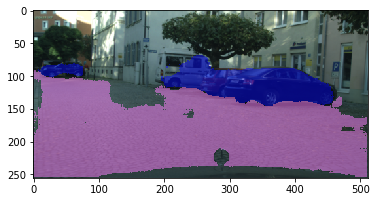

file name:lindau_000018_000019.png loss:0.28667619824409485


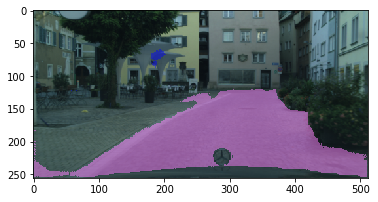

file name:munster_000148_000019.png loss:0.27217620611190796


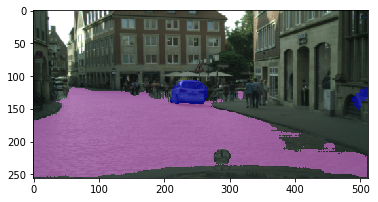

file name:lindau_000024_000019.png loss:0.27124300599098206


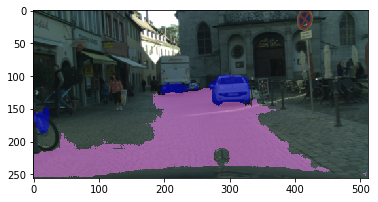

file name:lindau_000046_000019.png loss:0.26185524463653564


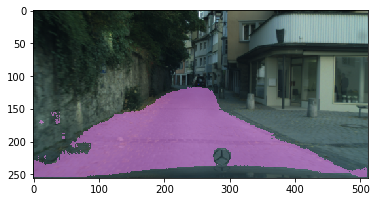

file name:lindau_000031_000019.png loss:0.2597150206565857


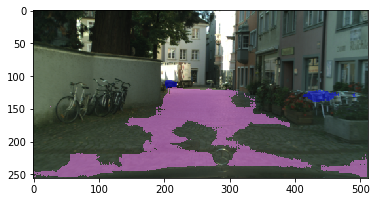

file name:frankfurt_000001_002759.png loss:0.20430894196033478


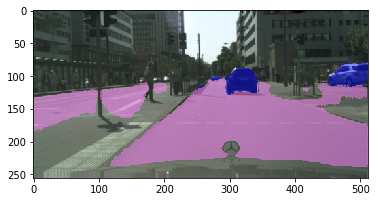

In [29]:
draw_large_loss_images()

file name:lindau_000035_000019.png loss:0.2941782474517822


/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


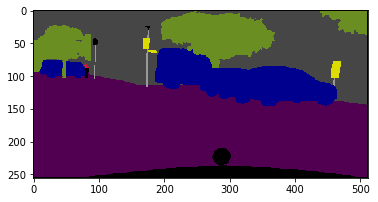

file name:lindau_000018_000019.png loss:0.28667619824409485


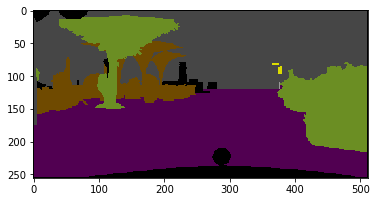

file name:munster_000148_000019.png loss:0.27217620611190796


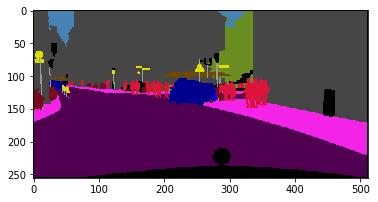

file name:lindau_000024_000019.png loss:0.27124300599098206


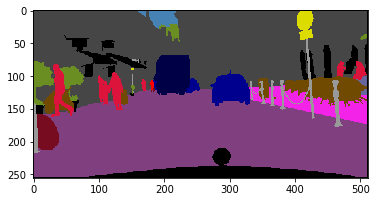

file name:lindau_000046_000019.png loss:0.26185524463653564


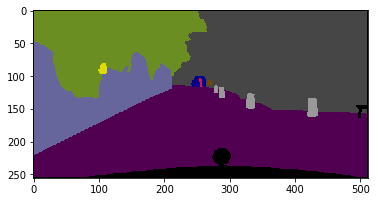

file name:lindau_000031_000019.png loss:0.2597150206565857


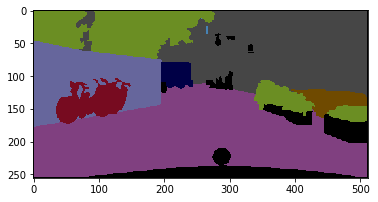

file name:frankfurt_000001_002759.png loss:0.20430894196033478


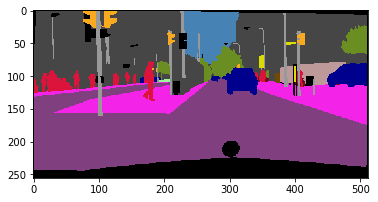

In [30]:
draw_large_loss_images(gt_dataset_dir)

In [ ]:
file name:lindau_000024_000019.png loss:0.27124300599098206
file name:lindau_000031_000019.png loss:0.2597150206565857
file name:frankfurt_000001_002759.png loss:0.20430894196033478